In [789]:
import pandas as pd
import numpy as np
import torch

import matplotlib.pyplot as plt


In [790]:
hnames = pd.read_csv("./data/hnames.csv", )
np.random.seed(16) # inital alphabetical order
hnames["name"] = np.random.permutation(hnames["name"])
hnames.head()

,name
0,tsuzumi tatehaya
1,esther archang
2,ayano miyamori
3,myuria rosa gallus
4,akari kisaragi


In [791]:
start_token = "."
end_token = "."

block_size = 5
dist_repr_dim = 2
batch_size = 32
layer1_neurons = 150

In [814]:
chars = sorted(list(set("".join(hnames["name"]))))
chars = [start_token] + chars

char_to_idx = {char: idx for idx, char in enumerate(chars)}
idx_to_char = {idx: char for idx, char in enumerate(chars)}
char_to_idx

{'.': 0,
 ' ': 1,
 '-': 2,
 'a': 3,
 'b': 4,
 'c': 5,
 'd': 6,
 'e': 7,
 'f': 8,
 'g': 9,
 'h': 10,
 'i': 11,
 'j': 12,
 'k': 13,
 'l': 14,
 'm': 15,
 'n': 16,
 'o': 17,
 'p': 18,
 'q': 19,
 'r': 20,
 's': 21,
 't': 22,
 'u': 23,
 'v': 24,
 'w': 25,
 'x': 26,
 'y': 27,
 'z': 28}

In [793]:
xs = []
ys = []
for name in hnames["name"]:
    name = name + end_token
    context = start_token * block_size
    for char in name:
        xs.append([char_to_idx[ctx_char] for ctx_char in context])
        ys.append(char_to_idx[char])
        # print(f"{context} -> {char}")
        
        context = context[1:] + char
        
X = torch.tensor(xs)
y = torch.tensor(ys)

X_oh: torch.Tensor = torch.nn.functional.one_hot(X).float()

X_oh.shape, X_oh.dtype, y.shape, y.dtype

(torch.Size([371786, 5, 29]), torch.float32, torch.Size([371786]), torch.int64)

In [794]:
X_oh_train = X_oh[:int(len(X_oh) * 0.8)]
y_train = y[:int(len(y) * 0.8)]
X_oh_val = X_oh[int(len(X_oh) * 0.8):int(len(X_oh) * 0.9)]
y_val = y[int(len(y) * 0.8):int(len(y) * 0.9)]
X_oh_test = X_oh[int(len(X_oh) * 0.9):]
y_test = y[int(len(y) * 0.9):]

print(X_oh_train.shape, y_train.shape)
print(X_oh_val.shape, y_val.shape)
print(X_oh_test.shape, y_test.shape)

torch.Size([297428, 5, 29]) torch.Size([297428])
torch.Size([37179, 5, 29]) torch.Size([37179])
torch.Size([37179, 5, 29]) torch.Size([37179])


In [795]:
generator = torch.Generator().manual_seed(16)

C = torch.randn((len(chars), dist_repr_dim), generator=generator)
W1 = torch.randn((block_size * dist_repr_dim, layer1_neurons), generator=generator)
b1 = torch.randn((layer1_neurons,), generator=generator)
W2 = torch.randn((layer1_neurons, len(chars)), generator=generator)
b2 = torch.randn((len(chars),), generator=generator)

params = [C, W1, b1, W2, b2]
for p in params:
    p.requires_grad = True

sum([p.nelement() for p in params])

6087

In [804]:
# batch_size = 256
for idx in range(30000):
    batch_idxs = torch.randint(0, X_oh_train.shape[0], (batch_size,))
    X_batch = X_oh_train[batch_idxs]
    y_batch = y_train[batch_idxs]

    emb = X_batch @ C # distributed representation
    emb_unbound = emb.unbind(dim=1) # block_size # of (m, dist_repr_dim) matrices
    emb = torch.cat(emb_unbound, dim=1) # (m, block_size * dist_repre_dim) matrix
    h = (emb @ W1 + b1).tanh()
    logits = h @ W2 + b2
    # logits_max = logits.max() # avoid e^100 overflow
    # logits_behaved = logits - logits_max
    # counts = logits_behaved.exp() # softmax
    # probs = counts / counts.sum(dim=1, keepdim=True)
    # probs_of_interest = probs[torch.arange(logits.shape[0]), y_batch]
    # loss = probs_of_interest.log().mean() * -1 # negative log likelihood
    loss = torch.nn.functional.cross_entropy(logits, y_batch) # fused kernel + faster backwards (tanh _backward)
    # print(loss)

    for p in params: # flushing
        p.grad = None
    loss.backward()
    for p in params:
        if 
        p.data += -0.1 * p.grad # 90k iters 2.2 something
        # p.data += -0.01 * p.grad # 30k iters 2.0137
        # higher batch size 256 # 30k iters 1.996

In [805]:
emb = X_oh_train @ C
emb_unbound = emb.unbind(dim=1) # block_size # of (m, dist_repr_dim) matrices
emb = torch.cat(emb_unbound, dim=1) # (m, block_size * dist_repre_dim) matrix
h = (emb @ W1 + b1).tanh()
logits = h @ W2 + b2
loss = torch.nn.functional.cross_entropy(logits, y_train) # fused kernel + faster backwards (tanh _backward)
loss

tensor(1.9996, grad_fn=<NllLossBackward0>)

In [806]:
emb = X_oh_val @ C
emb_unbound = emb.unbind(dim=1) # block_size # of (m, dist_repr_dim) matrices
emb = torch.cat(emb_unbound, dim=1) # (m, block_size * dist_repre_dim) matrix
h = (emb @ W1 + b1).tanh()
logits = h @ W2 + b2
loss = torch.nn.functional.cross_entropy(logits, y_val) # fused kernel + faster backwards (tanh _backward)
loss

tensor(2.0015, grad_fn=<NllLossBackward0>)

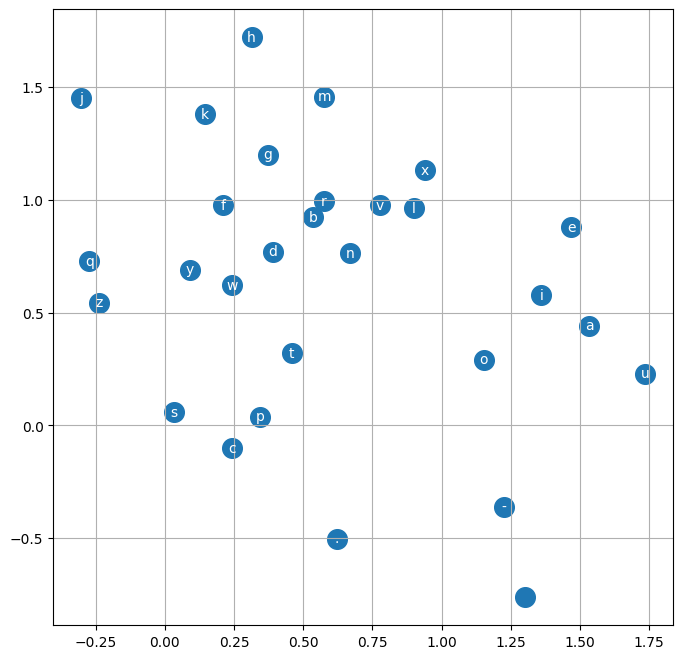

In [808]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for idx in range(C.shape[0]):
    plt.text(C[idx, 0].item(), C[idx, 1].item(), idx_to_char[idx], ha="center", va="center", color="white")
plt.grid("minor")

In [822]:
torch.save(C, "C.pt")
torch.save(W1, "W1.pt")
torch.save(b1, "b1.pt")
torch.save(W2, "W2.pt")
torch.save(b2, "b2.pt")

C_test = torch.load("C.pt")
(C_test == C).all()

tensor(True)

In [824]:
generator = torch.Generator().manual_seed(16)
for _ in range(10):
    sampled_chars = [0] * block_size
    while True:
        context = torch.tensor([sampled_chars[-block_size:]])
        context: torch.Tensor = torch.nn.functional.one_hot(context, num_classes=len(chars)).float()
        emb = torch.cat((context @ C).unbind(dim=1), dim=1)
        h = (emb @ W1 + b1).tanh()
        logits = h @ W2 + b2
        
        logits_max = logits.max() # avoid e^100 overflow
        logits_behaved = logits - logits_max
        counts = logits_behaved.exp() # softmax
        probs = counts / counts.sum(dim=1, keepdim=True)
        
        next_char_idx = torch.multinomial(probs, 1, generator=generator).item()
        sampled_chars.append(next_char_idx)
        
        if sampled_chars[-1] == 0 or sampled_chars[-1] == 1:
            sample = "".join(idx_to_char[idx] for idx in sampled_chars)
            print(sample.replace(".", "").replace(" ", ""))
            break

cayyaki
narlyawa
lakara
sestre
yuu
eonousu
satsubagi
rasakine
hirlaw
sostarugi
